## Over the previous tutorials, we have seen various stages of data reduction:
* Reading in light curve data
* Smoothing and removing outliers from light curves
* running BLS/TLS to find periodic events

In our smoothing and outlier removal steps, there are quite a few lines of code used. The [Lightkurve Python Module](https://docs.lightkurve.org/index.html) can do these steps in a single line in addition to other useful steps. See tutorials for more examples:

[https://docs.lightkurve.org/tutorials/index.html](https://docs.lightkurve.org/tutorials/index.html)

In [1]:
import lightkurve as lk

Lightkurve (lk) has a custom Python class called LightCurve, which has many commands such as .flatten and .bin

Lightkurve's flatten command also utilizes a Savitsky-Golay filter. Read more about it here:
[https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html?highlight=flatten#lightkurve.lightcurve.LightCurve.flatten](https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html?highlight=flatten#lightkurve.lightcurve.LightCurve.flatten)

Lightkurve's bin command is pretty straight forward to use as well. Read more about it here: 
[https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html?highlight=bin#lightkurve.lightcurve.LightCurve.bin](https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html?highlight=bin#lightkurve.lightcurve.LightCurve.bin)

/Users/felizd/anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


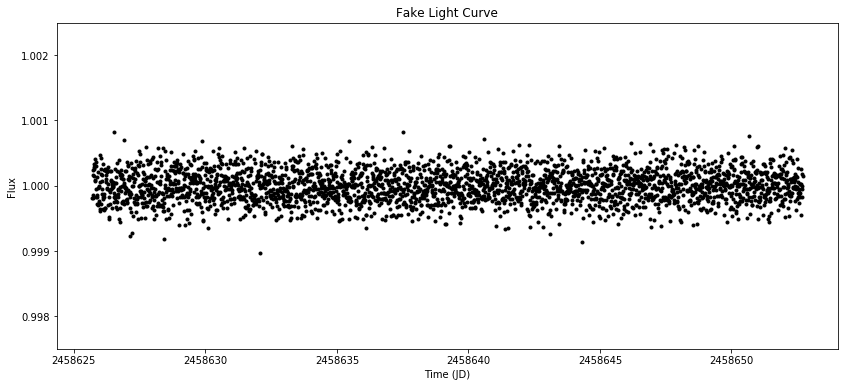

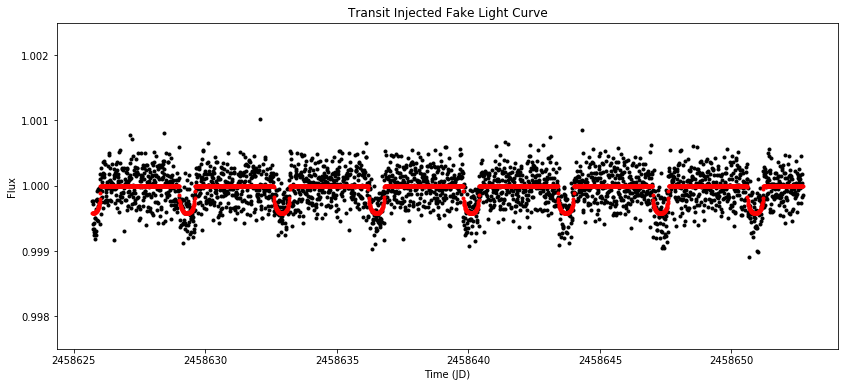

In [45]:
# Let's start with a fake light curve with a planet injected into it.
import batman
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
from pylab import *
from astropy.stats import BoxLeastSquares
from transitleastsquares import period_grid


def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)





fs=10 #fontsize for text in figures

ndays = 27 #days
cadence= 0.0208333 #take measurement twice an hour in units of days
pts_per_day = 5000*cadence #data points per day
scatter_frac = 0.00025  # add scatter to data to make it realistic

start=0.0
stop=ndays
stepsize=ndays*pts_per_day
t = 2458625.7 + np.linspace(start, stop, stepsize) 

flux = 1.0 + np.random.randn(t.size) * scatter_frac
fluxerr = np.ones_like(flux) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()

Rad_sun = 6.955*10.0**10.0 #cm
Rad_earth = 6.378*10.0**8.0 #cm
Mass_Sun = 1.989*10.0**33.0 #grams

time_start = t[0] #[0] =first data point in array

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = 3.6  # orbital period
ma.rp = 2.0*Rad_earth/Rad_sun  # planet radius (in units of stellar radii) 
ma.a = 2  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, t)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

injectedflux = synthetic_signal- flux+1

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,injectedflux,marker='.',color='black',linestyle='none')
plt.plot(t,synthetic_signal,marker='.',color='red',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()

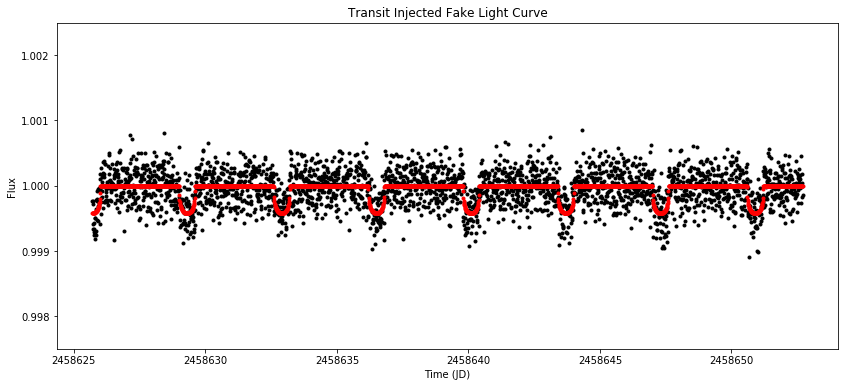

Window size:  241  and bin size:  3
 


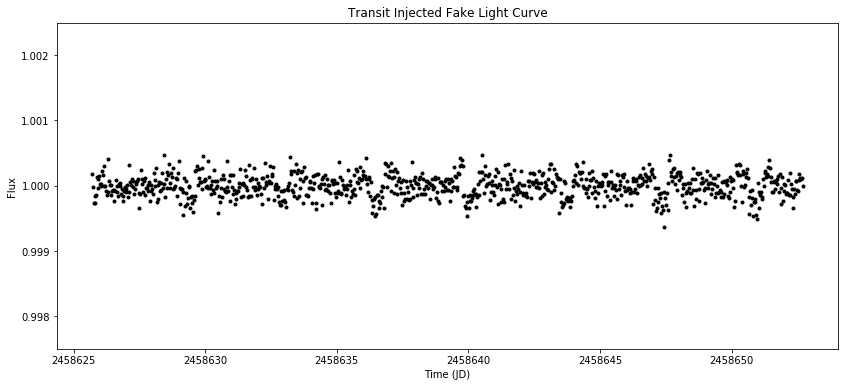

 
number of data points before outlier rejection 2812
number of data points after outlier rejection 2811
number of data points after smoothing and binning 937


In [79]:
t2,f2,fe2 = ChauventsCriteron(t,injectedflux,fluxerr)


plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

# plt.plot(t,injectedflux,marker='.',color='black',linestyle='none') #for comparison, only a few data points removed
plt.plot(t2,f2,marker='.',color='k',linestyle='none')
plt.plot(t,synthetic_signal,marker='.',color='red',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()


lc = lk.LightCurve(t2,f2,fe2)

cad = 0.0208333 #30 minutes in days

#now let's define a window size to smooth our data with:

window_size = int(5.0/cad) #number of data points in 5 hours
if (window_size % 2) == 0: #must be odd. If not, there will be an error
    window_size = window_size+1

bin_size= 3 # Number of cadences to include in every bin. 
# NOTE: ^^^ This is different from our previously used bin sizes which were in units of days.

print("Window size: ", window_size," and bin size: ", bin_size)
print(" ")

detrended_lc = lc.flatten(window_length=window_size,polyorder=3, niters=10).bin(binsize=bin_size)

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)


plt.plot(detrended_lc.time, detrended_lc.flux,'k.') #note the use of .time and .flux for this object class

plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()


print(" ")
print("number of data points before outlier rejection", len(t))
print("number of data points after outlier rejection", len(t2))
print("number of data points after smoothing and binning", len(detrended_lc.time))

# This is a much more condensed processed than our scripts. This can be useful to process large amounts of data. Let's see how it compares with our previous procedure.

A useful metric to describe how much scatter is in a data set is by measure it's Root Mean Square (RMS):

For a set of N numbers:

$ \LARGE y_{RMS} = \sqrt{\frac{ \sum_{N=1}^{\infty} (y_{mean} - 1)^2  }{N}}$

This basically tells you how big the scatter is in a data set. We have $ \large (y_{mean} - 1)$ because our light curve is normalized to 1. For any other data set, this numerator would be

$ \large \sum_{N=1}^{\infty} (y_{mean} - y_N)^2 $

In [80]:
#lightkurve method:
lk_rms = np.sqrt(np.mean((detrended_lc.flux)**2))
print("RMS of lightkurve detrended data: ", lk_rms)

RMS of lightkurve detrended data:  0.9999976946005495


In [87]:
# Let's bring in our older tools

#custom binning function
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr


def SmoothAndRemove(time,flux,flux_error,iterations):
    
    cad = time[1]-time[0]
    #now let's define a window size to smooth our data with:

    window_size = int(5.0/cad) #number of data points in 5 hours
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1

    
    # lets smooth for a total of 10 times. Experiment with more or less iterations:
    
    o = np.ones(len(flux), dtype=bool)
    for i in range(10):  #Note: You can place a for-loop inside a for-loop!
        y_prime = np.interp(time, time[o], flux[o])
        smooth = savgol_filter(y_prime, window_size, polyorder=3)
        resid = flux - smooth +1 #add the one to have it centered on 1.0 instead of 0.0
        sigma = np.sqrt(np.mean(resid**2)) #root mean square (RMS for short)
        o0 = np.abs(resid) < 3*sigma #this is shorthand for: -3*sigma < resid < 3*sigma
        if o.sum() == o0.sum():
            o = o0
            break
        o = o0

    # Only discard positive outliers
    o = resid < 3.0*sigma

    #removing outliers with Chauvenet's criterion after smoothing
    newtime,newflux,newflux_error = ChauventsCriteron(time,resid,flux_error)
    
    return newtime,newflux,newflux_error,window_size

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #these are annoying.

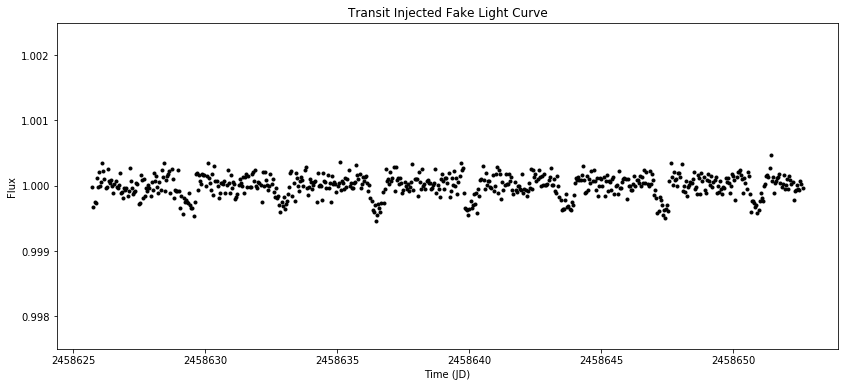

In [88]:
# smoothing and outlier rejection with previous procedure
newtime,newflux,newflux_error,window_size = SmoothAndRemove(t,injectedflux,fluxerr,10)

binsize= 60.0/(60.0*24.0)  #60 minutes in units of days
bint,binf,binfe = Bin_func(newtime, newflux,newflux_error,binsize)



plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(bint,binf, 'k.')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.show()


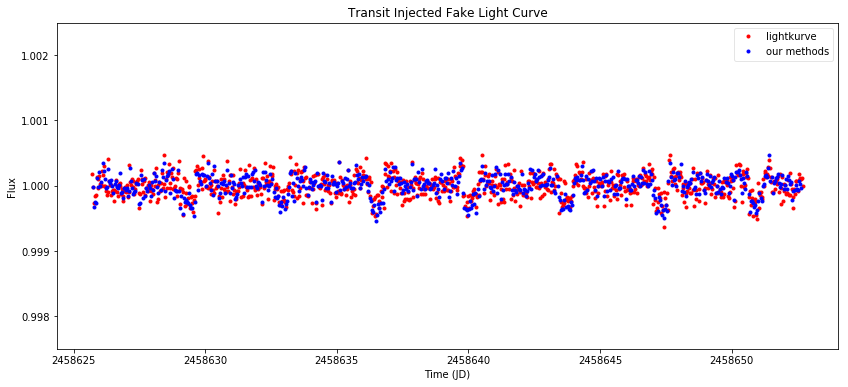

In [89]:
# Let's see how they looked plooted on top of each other

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)


plt.plot(detrended_lc.time, detrended_lc.flux,'r.',label='lightkurve') #note the use of .time and .flux for this object class
plt.plot(bint,binf, 'b.',label='our methods')

plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
plt.ylim(0.9975,1.0025)
plt.legend(loc='best',fancybox=True,framealpha=0.5)
plt.show()


In [93]:
#lightkurve method:
lk_rms = np.sqrt(np.mean((detrended_lc.flux-1.0)**2))
print("RMS of lightkurve detrended data: ", lk_rms)

print(" ")

SmoothRemoveAndBin_rms = np.sqrt(np.mean((binf-1.0)**2))
print("RMS of our detrended data: ", SmoothRemoveAndBin_rms)

RMS of lightkurve detrended data:  0.00017193800019037116
 
RMS of our detrended data:  0.00016747232472654247


## In this case, our old procedure performs slightly better than the lightkurve module but there is a lot of things done "behind the scenes" in lightkurve that make it much more user friendly. My example use of Lightkurve can be further optimized to reduce the RMS but this is also true for our smoothing, outlier removal and binning procedures.